### Setup

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
from datetime import datetime, timedelta
import time
import numpy as np

from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
crash = pd.read_csv('crash_clean.csv', index_col=0)
au_pop = pd.read_csv('AustinPop.csv')

In [3]:
crash["Crash_Date"] = pd.to_datetime(crash["Crash_Date"], format= "%m/%d/%Y")

crash["time_segment"] = np.where((crash["Crash_Date"] <= pd.Timestamp(2014,6,1)),"before", 
                              np.where((crash["Crash_Date"] > pd.Timestamp(2014,6,1)) & (crash["Crash_Date"] <= pd.Timestamp(2016,5,10)), "entry",
                                       np.where((crash["Crash_Date"] > pd.Timestamp(2016,5,10)) & (crash["Crash_Date"] <= pd.Timestamp(2017,5,29)), "exit",
                                                np.where((crash["Crash_Date"] > pd.Timestamp(2017,5,29)), "re-entry",
                                                         "error"))))
crash["uber_present"] = np.where((crash["Crash_Date"] <= pd.Timestamp(2014,6,1)),0, 
                              np.where((crash["Crash_Date"] > pd.Timestamp(2014,6,1)) & (crash["Crash_Date"] <= pd.Timestamp(2016,5,10)), 1,
                                       np.where((crash["Crash_Date"] > pd.Timestamp(2016,5,10)) & (crash["Crash_Date"] <= pd.Timestamp(2017,5,29)), 0,
                                                np.where((crash["Crash_Date"] > pd.Timestamp(2017,5,29)), 1,
                                                         "error"))))
# crash["bins"] = np.where((crash["Crash_Date"] <= dt.date(2010,1,11)),-7, 
#                       np.where((crash["Crash_Date"] > dt.date(2010,1,12)) & (crash["Crash_Date"] <= dt.date(2011,2,1)), -6,
#                           np.where((crash["Crash_Date"] > dt.date(2011,2,1)) & (crash["Crash_Date"] <= dt.date(2012,2,21)), -5,
#                               np.where((crash["Crash_Date"] > dt.date(2012,2,21)) & (crash["Crash_Date"] <= dt.date(2013,3,12)), -4,
#                                   np.where((crash["Crash_Date"] > dt.date(2013,3,12)) & (crash["Crash_Date"] <= dt.date(2014,4,1)), -3,
#                                          np.where((crash["Crash_Date"] > dt.date(2014,4,1)) & (crash["Crash_Date"] <= dt.date(2015,4,21)), -2,
#                                             np.where((crash["Crash_Date"] > dt.date(2015,4,21)) & (crash["Crash_Date"] <= dt.date(2016,5,10)), -1,
#                                                np.where((crash["Crash_Date"] > dt.date(2016,5,10)) & (crash["Crash_Date"] <= dt.date(2017,5,29)), 0,
#                                                     np.where((crash["Crash_Date"] > dt.date(2017,5,29)) & (crash["Crash_Date"] <= dt.date(2018,6,19)), 1,
#                                                         np.where((crash["Crash_Date"] > dt.date(2018,6,19)) & (crash["Crash_Date"] <= dt.date(2019,7,9)), 2,
#                                                            np.where((crash["Crash_Date"] > dt.date(2019,7,9)) & (crash["Crash_Date"] <= dt.date(2020,7,28)), 3,
#                                                                 np.where((crash["Crash_Date"] > dt.date(2020,7,28)), 4,"error"))))))))))))

In [4]:
crash_gb = crash[['Crash_ID','Crash_Date']]

In [5]:
crash_gb = crash_gb.set_index('Crash_Date')

In [6]:
annual_crash_numbers = crash_gb.resample('Y').count()

In [7]:
ann_crashes_normalized = annual_crash_numbers
ann_crashes_normalized = ann_crashes_normalized.reset_index()

In [8]:
ann_crashes_normalized['Crash_ID'] = ann_crashes_normalized['Crash_ID']/au_pop['Population']

In [9]:
ann_crashes_normalized = ann_crashes_normalized.rename({'Crash_ID' : 'Crashes per Person'}, axis='columns')

In [10]:
# plt.figure(num=None, figsize=(10,10), dpi=80, facecolor='w', edgecolor='k')

# plt.plot(ann_crashes_normalized['Crash_Date'][:-2],ann_crashes_normalized['Crashes per Person'][:-2],marker="o")

# #plt.annotate(dt.date(2014,6,1), dt.date(2016,5,10)):
# plt.annotate("Uber Enters Austin Market", xy=(dt.date(2014,6,1),0.0162), xycoords='data',
#             bbox=dict(boxstyle="round", fc="none", ec="gray"),
#             xytext=(-60, -40), textcoords='offset points', ha='center',
#             arrowprops=dict(arrowstyle="->"))

# plt.annotate("Uber Leaves Austin Market", xy=(dt.date(2016,5,1),0.0174), xycoords='data',
#             bbox=dict(boxstyle="round", fc="none", ec="gray"),
#             xytext=(50, -80), textcoords='offset points', ha='center',
#             arrowprops=dict(arrowstyle="->"))


# plt.annotate("Uber Returns", xy=(dt.date(2017,5,29),0.018), xycoords='data',
#             bbox=dict(boxstyle="round", fc="none", ec="gray"),
#             xytext=(30,20), textcoords='offset points', ha='center',
#             arrowprops=dict(arrowstyle="->"))

## Analyzing Location of crashes at different time periods

In [11]:
#Set up time_segment # of months

cols = ["before", "entry", "exit", "re-entry"]
seg_months = [52.5, 23, 12.5, 27.5]

df_time_segment_months = pd.DataFrame([seg_months])
df_time_segment_months.columns =cols
df_time_segment_months = df_time_segment_months.T
df_time_segment_months.columns = ["months_in_segment"]
df_time_segment_months["time_segment"] = df_time_segment_months.index
df_time_segment_months.head()

,months_in_segment,time_segment
before,52.5,before
entry,23.0,entry
exit,12.5,exit
re-entry,27.5,re-entry


In [12]:
#import population for normalization
df_pop = pd.read_csv("AustinMonthlyPop.csv")
df_pop.rename(columns={"Unnamed: 1":"Month"}, inplace=True)
df_pop.head()

,Year,Month,Population
0,2010,1,797593
1,2010,2,799287
2,2010,3,800998
3,2010,4,802767
4,2010,5,804584


In [13]:
#Merge dataframe with population and normalize
df_heatmap = crash[["Latitude","Longitude", "time_segment","Crash_Date", "Crash_Time"]].copy()
df_heatmap["Month"] = pd.DatetimeIndex(df_heatmap['Crash_Date']).month
df_heatmap["Year"] = pd.DatetimeIndex(df_heatmap['Crash_Date']).year
df_heatmap = df_heatmap.merge(df_pop, on=["Year", "Month"], how="left")
df_heatmap["Crash_Norm"] = 1/(df_heatmap["Population"]/10**3) #Convert to crashes per thousand people

#Merge df with segmentation before, entry, exit, re-entry 
df_heatmap = df_heatmap.merge(df_time_segment_months, on="time_segment", how="left")

#Create a population normalized and annualized value for each crash for aggregation below
#Value is crash per 1,000 residents per months in time segment (for annualization)
df_heatmap["Crash_Norm_Annual"] = df_heatmap["Crash_Norm"] / (df_heatmap["months_in_segment"]/12) #Annualize data

In [14]:
df_heatmap.head()

,Latitude,Longitude,time_segment,Crash_Date,Crash_Time,Month,Year,Population,Crash_Norm,months_in_segment,Crash_Norm_Annual
0,30.376001,-97.673639,before,2010-01-15,12:06 PM,1,2010,797593,0.001254,52.5,0.000287
1,30.307715,-97.726472,before,2010-01-15,04:32 PM,1,2010,797593,0.001254,52.5,0.000287
2,30.265225,-97.740032,before,2010-01-13,06:38 PM,1,2010,797593,0.001254,52.5,0.000287
3,30.300115,-97.732672,before,2010-01-13,03:47 PM,1,2010,797593,0.001254,52.5,0.000287
4,30.292341,-97.721250,before,2010-01-12,04:51 PM,1,2010,797593,0.001254,52.5,0.000287


In [15]:
#Select relevant columns
df_heatmap_output = df_heatmap[["Latitude", "Longitude", "time_segment", "Crash_Date", "Crash_Time", "Crash_Norm_Annual"]]
df_heatmap_output = df_heatmap_output.dropna()

#Export for data exploration in Tableau
# df_heatmap_output.to_csv("Normalized Crash Data for Heatmap")

In [16]:
#Round to a higher lat long
def rounder_3(x):
    return round(x,3)

def rounder_2(x):
    return round(x,2)

def rounder_1(x):
    return round(x,1)

In [17]:
#create rounded latitudes and longitudes
df_heatmap_output["lat_3"] = df_heatmap_output["Latitude"].apply(rounder_3)
df_heatmap_output["lat_2"] = df_heatmap_output["Latitude"].apply(rounder_2)
df_heatmap_output["lat_1"] = df_heatmap_output["Latitude"].apply(rounder_1)

df_heatmap_output["lon_3"] = df_heatmap_output["Longitude"].apply(rounder_3)
df_heatmap_output["lon_2"] = df_heatmap_output["Longitude"].apply(rounder_2)
df_heatmap_output["lon_1"] = df_heatmap_output["Longitude"].apply(rounder_1)

df_heatmap_output.head()

,Latitude,Longitude,time_segment,Crash_Date,Crash_Time,Crash_Norm_Annual,lat_3,lat_2,lat_1,lon_3,lon_2,lon_1
0,30.376001,-97.673639,before,2010-01-15,12:06 PM,0.000287,30.376,30.38,30.4,-97.674,-97.67,-97.7
1,30.307715,-97.726472,before,2010-01-15,04:32 PM,0.000287,30.308,30.31,30.3,-97.726,-97.73,-97.7
2,30.265225,-97.740032,before,2010-01-13,06:38 PM,0.000287,30.265,30.27,30.3,-97.740,-97.74,-97.7
3,30.300115,-97.732672,before,2010-01-13,03:47 PM,0.000287,30.300,30.30,30.3,-97.733,-97.73,-97.7
4,30.292341,-97.721250,before,2010-01-12,04:51 PM,0.000287,30.292,30.29,30.3,-97.721,-97.72,-97.7


In [18]:
#create columns from time_segment so can take difference between lat_2 lon_2's

df_heatmap_output = df_heatmap_output.groupby(["lat_2", "lon_2", "time_segment"])[["Crash_Norm_Annual"]].sum().reset_index()

df_heatmap_changes = df_heatmap_output.pivot_table(values='Crash_Norm_Annual', index=['lat_2', 'lon_2'], 
                                                   columns="time_segment").reset_index().fillna(0)
df_heatmap_changes.head()

time_segment,lat_2,lon_2,before,entry,exit,re-entry
0,30.10,-97.81,0.004110,0.003966,0.011168,0.008554
1,30.11,-97.81,0.011174,0.028268,0.032476,0.032336
2,30.11,-97.80,0.000254,0.000570,0.001019,0.000000
3,30.11,-97.79,0.000538,0.003381,0.002028,0.004053
4,30.12,-97.81,0.000814,0.001693,0.002033,0.004984


In [19]:
#calc differences between time periods
df_heatmap_changes["entry_change"] = df_heatmap_changes["entry"] - df_heatmap_changes["before"]
df_heatmap_changes["exit_change"] = df_heatmap_changes["exit"] - df_heatmap_changes["before"]
df_heatmap_changes["re-entry_change"] = df_heatmap_changes["re-entry"] - df_heatmap_changes["before"]
df_heatmap_changes.head()

time_segment,lat_2,lon_2,before,entry,exit,re-entry,entry_change,exit_change,re-entry_change
0,30.10,-97.81,0.004110,0.003966,0.011168,0.008554,-0.000144,0.007058,0.004445
1,30.11,-97.81,0.011174,0.028268,0.032476,0.032336,0.017093,0.021301,0.021161
2,30.11,-97.80,0.000254,0.000570,0.001019,0.000000,0.000316,0.000765,-0.000254
3,30.11,-97.79,0.000538,0.003381,0.002028,0.004053,0.002843,0.001490,0.003515
4,30.12,-97.81,0.000814,0.001693,0.002033,0.004984,0.000879,0.001220,0.004171


In [20]:
#Export for Tableua
df_heatmap_changes.to_csv("normalized_crash_data_heatmap_withchanges")

In [21]:
#Sum up downton lat lons
df_heatmap_changes["lat_lon_concat"] = df_heatmap_changes["lat_2"].map(str) + ", " + df_heatmap_changes["lon_2"].map(str)

downtown = ["30.28, -97.75", "30.27, -97.75", "30.26, -97.74", "30.27, -97.74", "30.28, -97.74"]
df_heatmap_downtown = df_heatmap_changes.loc[(df_heatmap_changes['lat_lon_concat'] == downtown[0]) |
                                            (df_heatmap_changes['lat_lon_concat'] == downtown[1]) |
                                            (df_heatmap_changes['lat_lon_concat'] == downtown[2]) |
                                             (df_heatmap_changes['lat_lon_concat'] == downtown[3]) |
                                             (df_heatmap_changes['lat_lon_concat'] == downtown[4])
                                            ] 

df_heatmap_downtown = df_heatmap_downtown[["before", "entry_change", "exit_change", "re-entry_change"]]
df_heatmap_downtown["entry_change"]
df_heatmap_downtown.head()

time_segment,before,entry_change,exit_change,re-entry_change
281,0.167654,0.011612,0.049721,0.034443
296,0.144533,-0.021287,0.013953,-0.013325
297,0.242769,-0.037783,-0.019238,-0.044290
313,0.077367,-0.021266,-0.010263,-0.018543
314,0.123991,-0.008805,0.020280,0.023551


In [22]:
dt_values = []
for i in range(3):
    percent = (df_heatmap_downtown.sum(axis=0)[i+1] / df_heatmap_downtown.sum(axis=0)[0]) * 100
    dt_values.append(percent)
dt_values

[-10.250940041120614, 7.199740996322836, -2.4017155009226463]

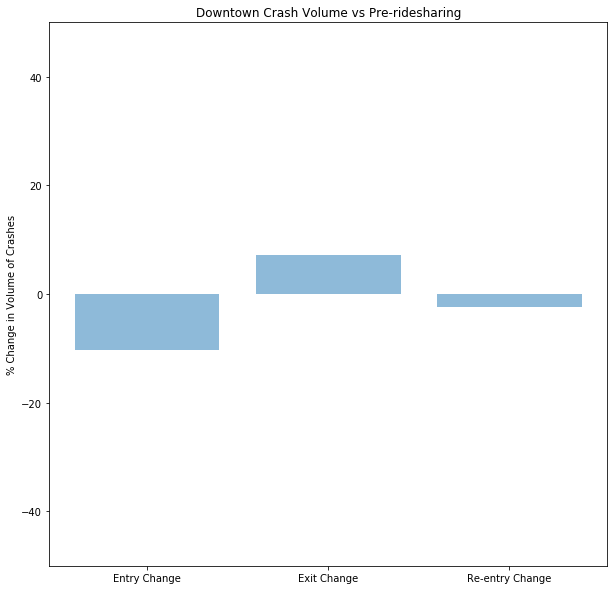

In [23]:
plt.figure(figsize=(10, 10))
labels = ('Entry Change', 'Exit Change', "Re-entry Change")
y_pos = np.arange(len(labels))

plt.bar(y_pos, dt_values, align='center', alpha=0.5)
plt.xticks(y_pos, labels)
plt.ylabel('% Change in Volume of Crashes')
plt.title('Downtown Crash Volume vs Pre-ridesharing')
plt.ylim([-50, 50])
plt.show()

In [24]:
#setup university location
university = ["30.29, -97.75", "30.29, -97.74", "30.29, -97.73", "30.3, -97.73", "30.3, -97.74", "30.3, -97.75"]

df_heatmap_university = df_heatmap_changes.loc[(df_heatmap_changes['lat_lon_concat'] == university[0]) |
                                            (df_heatmap_changes['lat_lon_concat'] == university[1]) |
                                            (df_heatmap_changes['lat_lon_concat'] == university[2]) |
                                             (df_heatmap_changes['lat_lon_concat'] == university[3]) |
                                               (df_heatmap_changes['lat_lon_concat'] == university[4]) |
                                             (df_heatmap_changes['lat_lon_concat'] == university[5])
                                            ] 

df_heatmap_university = df_heatmap_university[["before","entry_change", "exit_change", "re-entry_change"]]
df_heatmap_university.head(6)

time_segment,before,entry_change,exit_change,re-entry_change
334,0.076546,-0.024879,0.003739,-0.041023
335,0.092204,-0.030411,-0.033332,-0.014112
336,0.047774,-0.010450,-0.008173,0.003947
351,0.027206,-0.011339,-0.009936,-0.009670
352,0.083823,-0.030580,-0.014790,-0.015496
353,0.030016,-0.017559,-0.007665,-0.013334


In [25]:
values = []
for i in range(3):
    percent = (df_heatmap_university.sum(axis=0)[i+1] / df_heatmap_university.sum(axis=0)[0]) * 100
    values.append(percent)
values

[-35.01928395757778, -19.620376749743563, -25.082607664879465]

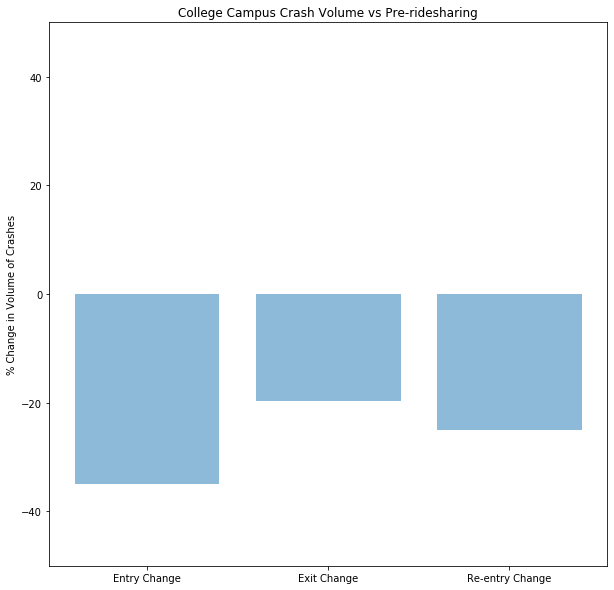

In [26]:
plt.figure(figsize=(10, 10))
labels = ('Entry Change', 'Exit Change', "Re-entry Change")
y_pos = np.arange(len(labels))

plt.bar(y_pos, values, align='center', alpha=0.5)
plt.xticks(y_pos, labels)
plt.ylabel('% Change in Volume of Crashes')
plt.title('College Campus Crash Volume vs Pre-ridesharing')
plt.ylim([-50,50])
plt.show()

In [27]:
#setup hyde park location
hyde = ["30.31, -97.74", "30.32, -97.73", "30.32, -97.72", "30.32, -97.71", 
        "30.31, -97.73", "30.31, -97.72", "30.31, -97.71", "30.3, -97.73", "30.3, -97.72"]
df_heatmap_hyde = df_heatmap_changes.loc[(df_heatmap_changes['lat_lon_concat'] == hyde[0]) |
                                            (df_heatmap_changes['lat_lon_concat'] == hyde[1]) |
                                            (df_heatmap_changes['lat_lon_concat'] == hyde[2]) |
                                             (df_heatmap_changes['lat_lon_concat'] == hyde[3]) |
                                             (df_heatmap_changes['lat_lon_concat'] == hyde[4]) |
                                             (df_heatmap_changes['lat_lon_concat'] == hyde[5]) |
                                             (df_heatmap_changes['lat_lon_concat'] == hyde[6]) |
                                             (df_heatmap_changes['lat_lon_concat'] == hyde[7]) |
                                             (df_heatmap_changes['lat_lon_concat'] == hyde[8])
                                            ] 

df_heatmap_hyde = df_heatmap_hyde[["before","entry_change", "exit_change", "re-entry_change"]]
df_heatmap_hyde

time_segment,before,entry_change,exit_change,re-entry_change
353,0.030016,-0.017559,-0.007665,-0.013334
354,0.105230,0.005164,0.013678,-0.011053
370,0.073596,-0.023212,-0.022805,-0.029478
371,0.041106,-0.002689,-0.001464,-0.004208
372,0.050331,-0.010033,-0.002577,-0.003987
373,0.194204,-0.019559,-0.027550,-0.037066
389,0.053303,-0.006424,-0.004587,-0.006089
390,0.030614,0.000486,0.013115,0.001228
391,0.158848,-0.021355,-0.026655,-0.055514


In [28]:
df_heatmap_changes.loc[(df_heatmap_changes['lat_lon_concat'] == hyde[8])]

time_segment,lat_2,lon_2,before,entry,exit,re-entry,entry_change,exit_change,re-entry_change,lat_lon_concat
354,30.3,-97.72,0.10523,0.110395,0.118908,0.094178,0.005164,0.013678,-0.011053,"30.3, -97.72"


In [29]:
values = []
for i in range(3):
    percent = (df_heatmap_hyde.sum(axis=0)[i+1] / df_heatmap_hyde.sum(axis=0)[0]) * 100
    values.append(percent)
values

[-12.910553251536816, -9.02118511847223, -21.634690975568212]

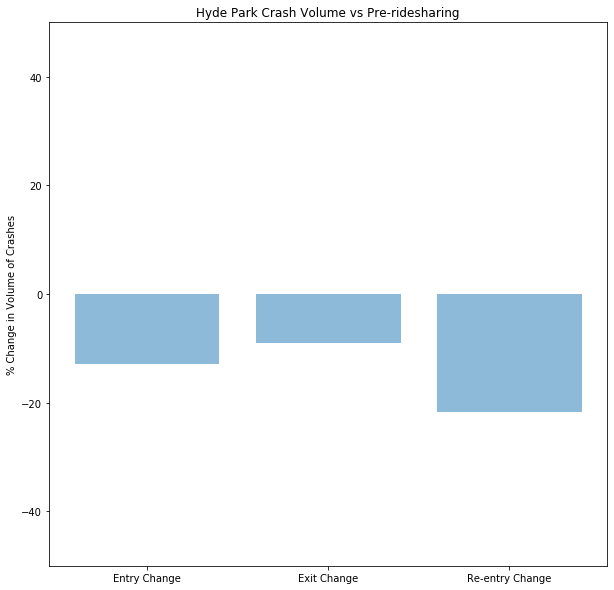

In [30]:
plt.figure(figsize=(10, 10))
labels = ('Entry Change', 'Exit Change', "Re-entry Change")
y_pos = np.arange(len(labels))

plt.bar(y_pos, values, align='center', alpha=0.5)
plt.xticks(y_pos, labels)
plt.ylabel('% Change in Volume of Crashes')
plt.title('Hyde Park Crash Volume vs Pre-ridesharing')
plt.ylim([-50,50])
plt.show()

In [31]:
#Create plots for Zilker and South Congress
#setup hyde park location
zilker = ["30.26, -97.78", "30.26, -97.77", "30.26, -97.76", "30.26, -97.75",
       "30.25, -97.79", "30.25, -97.78", "30.25, -97.77", "30.25, -97.76", "30.25, -97.75", "30.25, -97.74",
        "30.24, -97.78", "30.24, -97.77", "30.24, -97.76", "30.24, -97.75", "30.24, -97.74",
        "30.23, -97.8", "30.23, -97.79", "30.23, -97.78", "30.23, -97.77", "30.23, -97.76", "30.23, -97.75",
        "30.22, -97.76", "30.22, -97.75"
       ]
df_heatmap_zilker = df_heatmap_changes.loc[(df_heatmap_changes['lat_lon_concat'] == zilker[0]) |
                                            (df_heatmap_changes['lat_lon_concat'] == zilker[1]) |
                                            (df_heatmap_changes['lat_lon_concat'] == zilker[2]) |
                                             (df_heatmap_changes['lat_lon_concat'] == zilker[3]) |
                                             (df_heatmap_changes['lat_lon_concat'] == zilker[4]) |
                                             (df_heatmap_changes['lat_lon_concat'] == zilker[5]) |
                                             (df_heatmap_changes['lat_lon_concat'] == zilker[6]) |
                                             (df_heatmap_changes['lat_lon_concat'] == zilker[7]) |
                                             (df_heatmap_changes['lat_lon_concat'] == zilker[8]) |
                                             (df_heatmap_changes['lat_lon_concat'] == zilker[9]) |
                                             (df_heatmap_changes['lat_lon_concat'] == zilker[10]) |
                                             (df_heatmap_changes['lat_lon_concat'] == zilker[11]) |
                                             (df_heatmap_changes['lat_lon_concat'] == zilker[12]) |
                                             (df_heatmap_changes['lat_lon_concat'] == zilker[13]) |
                                             (df_heatmap_changes['lat_lon_concat'] == zilker[14]) |
                                             (df_heatmap_changes['lat_lon_concat'] == zilker[15]) |
                                             (df_heatmap_changes['lat_lon_concat'] == zilker[16]) |
                                             (df_heatmap_changes['lat_lon_concat'] == zilker[17]) |
                                             (df_heatmap_changes['lat_lon_concat'] == zilker[18]) |
                                             (df_heatmap_changes['lat_lon_concat'] == zilker[19]) |
                                             (df_heatmap_changes['lat_lon_concat'] == zilker[20]) |
                                             (df_heatmap_changes['lat_lon_concat'] == zilker[21]) |
                                             (df_heatmap_changes['lat_lon_concat'] == zilker[22])
                                          ] 

df_heatmap_zilker = df_heatmap_zilker[["before","entry_change", "exit_change", "re-entry_change"]]
df_heatmap_zilker.shape

(23, 4)

In [32]:
values = []
for i in range(3):
    percent = (df_heatmap_zilker.sum(axis=0)[i+1] / df_heatmap_zilker.sum(axis=0)[0]) * 100
    values.append(percent)
values

[3.3882526663296075, 17.088854680379683, 7.382786130918785]

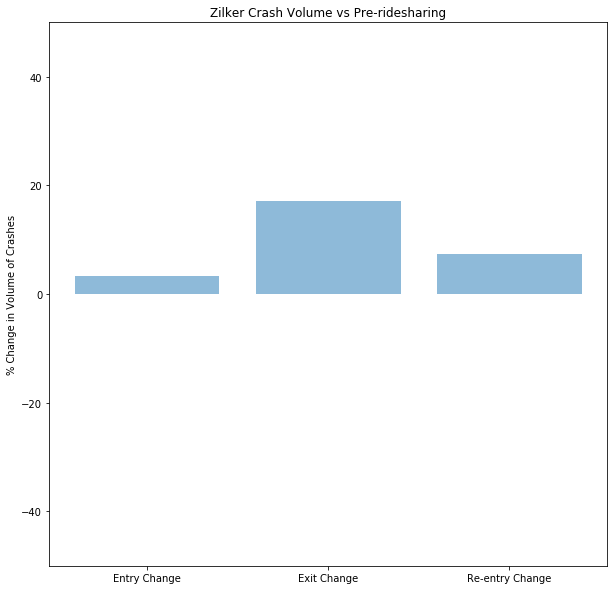

In [33]:
plt.figure(figsize=(10, 10))
labels = ('Entry Change', 'Exit Change', "Re-entry Change")
y_pos = np.arange(len(labels))

plt.bar(y_pos, values, align='center', alpha=0.5)
plt.xticks(y_pos, labels)
plt.ylabel('% Change in Volume of Crashes')
plt.title('Zilker Crash Volume vs Pre-ridesharing')
plt.ylim([-50,50])
plt.show()

In [34]:
#Create plots for Airport
#setup airport location
airport = ["30.24, -97.68", 
          "30.23, -97.68", "30.23, -97.67",
          "30.22, -97.68", "30.22, -97.67", "30.22, -97.66",
          "30.21, -97.68", "30.21, -97.67", "30.21, -97.66", "30.21, -97.65",
          "30.2, -97.68", "30.2, -97.67", "30.2, -97.66", "30.2, -97.65",
          "30.19, -97.68", "30.19, -97.67", "30.19, -97.66", "30.19, -97.65",
          "30.18, -97.68", "30.18, -97.65",
          "30.17, -97.67", "30.17, -97.66", "30.17, -97.65"
       ]
df_heatmap_airport = df_heatmap_changes.loc[(df_heatmap_changes['lat_lon_concat'] == airport[0]) |
                                            (df_heatmap_changes['lat_lon_concat'] == airport[1]) |
                                            (df_heatmap_changes['lat_lon_concat'] == airport[2]) |
                                             (df_heatmap_changes['lat_lon_concat'] == airport[3]) |
                                             (df_heatmap_changes['lat_lon_concat'] == airport[4]) |
                                             (df_heatmap_changes['lat_lon_concat'] == airport[5]) |
                                             (df_heatmap_changes['lat_lon_concat'] == airport[6]) |
                                             (df_heatmap_changes['lat_lon_concat'] == airport[7]) |
                                             (df_heatmap_changes['lat_lon_concat'] == airport[8]) |
                                             (df_heatmap_changes['lat_lon_concat'] == airport[9]) |
                                             (df_heatmap_changes['lat_lon_concat'] == airport[10]) |
                                             (df_heatmap_changes['lat_lon_concat'] == airport[11]) |
                                             (df_heatmap_changes['lat_lon_concat'] == airport[12]) |
                                             (df_heatmap_changes['lat_lon_concat'] == airport[13]) |
                                             (df_heatmap_changes['lat_lon_concat'] == airport[14]) |
                                             (df_heatmap_changes['lat_lon_concat'] == airport[15]) |
                                             (df_heatmap_changes['lat_lon_concat'] == airport[16]) |
                                             (df_heatmap_changes['lat_lon_concat'] == airport[17]) |
                                             (df_heatmap_changes['lat_lon_concat'] == airport[18]) |
                                             (df_heatmap_changes['lat_lon_concat'] == airport[19]) |
                                             (df_heatmap_changes['lat_lon_concat'] == airport[20]) |
                                             (df_heatmap_changes['lat_lon_concat'] == airport[21]) |
                                             (df_heatmap_changes['lat_lon_concat'] == airport[22])
                                          ] 

df_heatmap_airport = df_heatmap_airport[["before","entry_change", "exit_change", "re-entry_change"]]
df_heatmap_airport.shape

(23, 4)

In [35]:
values = []
for i in range(3):
    percent = (df_heatmap_airport.sum(axis=0)[i+1] / df_heatmap_airport.sum(axis=0)[0]) * 100
    values.append(percent)
values

[43.512341732492445, 74.0354962771478, 68.02257785632864]

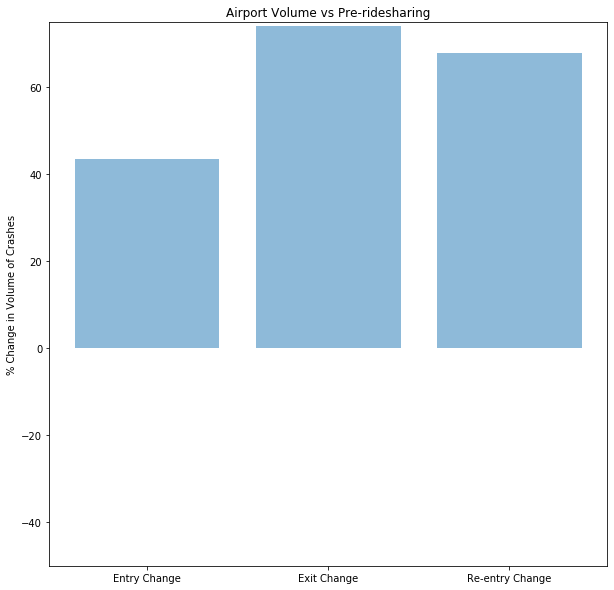

In [36]:
plt.figure(figsize=(10, 10))
labels = ('Entry Change', 'Exit Change', "Re-entry Change")
y_pos = np.arange(len(labels))

plt.bar(y_pos, values, align='center', alpha=0.5)
plt.xticks(y_pos, labels)
plt.ylabel('% Change in Volume of Crashes')
plt.title('Airport Volume vs Pre-ridesharing')
plt.ylim([-50,75])
plt.show()